# Develop a simple visualization prototype

We now have

* a simulator that reports sensor values
* a machine learning model that predicts whether any one sensor value is "normal" or an "outlier"

Let's combine these two into a small application. The application should:

1. Read the machine's most recent 100 values
2. Use the ML model to predict "normal" or "outlier" for each value
3. Plot the values + mark the outliers
4. Calculate and plot model drift

The steps 1 - 4 should be done in a loop, with updating the predictions and the plots once every second.

## Tasks

1. Study the code for each section and run it
2. 

In [22]:
# load a few imports
import os
import requests
import pandas as pd
import joblib
import numpy as np
import time

from matplotlib import pyplot as plt
from util import load_model, fix, read_data 

from IPython.display import clear_output

%matplotlib inline

# Get the data and transform it into a dataframe that we can use for reporting

We load the previously saved model and use it to predict outliers

In [23]:
alerts = {}

def get_report_data(model, alerts):
    # read the data from the machine API
    df = read_data(100)
    df['alert'] = False
    df['time'] = df.index
    # use the model to predict outliers
    y_hat = model.predict(fix(df['value']))
    # mark all outliers and record to alerts
    df['alert'] = y_hat == -1
    all_alerts = df[df['alert']]
    for i, row in all_alerts.iterrows():
        alerts.update({row.name: row['value']})
    return df, alerts

model = load_model('models/mymodel')
df, alerts = get_report_data(model, alerts)
df, alerts

(                               value  alert                       time
 dt                                                                    
 NaT                         0.000000  False                        NaT
 NaT                         0.000000  False                        NaT
 NaT                         0.000000  False                        NaT
 NaT                         0.000000  False                        NaT
 NaT                         0.000000  False                        NaT
 ...                              ...    ...                        ...
 2021-10-15 01:46:02.770817  0.070133  False 2021-10-15 01:46:02.770817
 2021-10-15 01:46:02.871202  0.132437  False 2021-10-15 01:46:02.871202
 2021-10-15 01:46:02.971531  0.009962  False 2021-10-15 01:46:02.971531
 2021-10-15 01:46:03.071827  0.162828  False 2021-10-15 01:46:03.071827
 2021-10-15 01:46:03.172083  0.001764  False 2021-10-15 01:46:03.172083
 
 [100 rows x 3 columns],
 {Timestamp('2021-10-15 01:46:00.4652

# Plot the sensor values

We want to plot all sensor values. For each alert we plot a vertical red line.

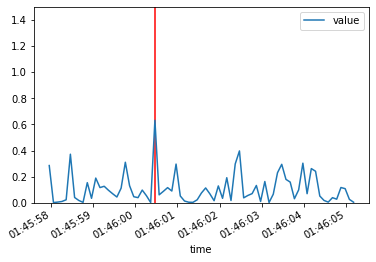

In [24]:
def plot_sensor_values(report_df):
    report_df.plot('time', 'value', ylim=(0, 1.5))
    alert_times = report_df['time'][report_df['alert']]
    plt.vlines(alert_times, 0, 1.5, color='r')
    
df, alerts = get_report_data(model, alerts)
plot_sensor_values(df)

# Create first version of application

We run all the code in a loop, so it updates automatically.

In [ ]:
train_data = pd.read_csv('datasets/traindata.csv')    
model = load_model('models/mymodel')
alerts = {}

while True:
    clear_output(wait=True)
    report_df, alerts = get_report_data(model, alerts)
    plot_sensor_values(report_df)
    plt.show()    
    print(alerts)
    time.sleep(1)  

# Calculate and plot model drift

We want to calculate and plot model drift. Model drift means:

* we know the expected distribution of predictions (i.e. the expected number of outliers, as per training data)
* we calculate the actual distribution of alerts seen in the sensor data retrieved from the machine

By comparing actual and expected distribution, we can easily see whether the model performs as expected. If the actual distribution 
of predictions is very different from the training data, something is wrong and we need to investigate.

Exercises:

1. Stop the machine simulator and change its configuration to "constant failure"
2. Rerun the below cell to see the difference


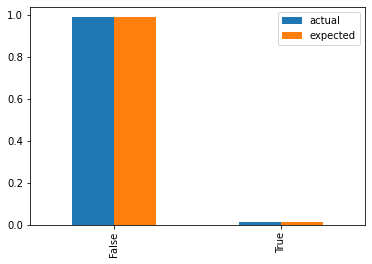

In [26]:
def calculate_expected_distribution(model, df):
    y_hat = model.predict(fix(df['value']))
    df['alert'] = y_hat == -1
    return df['alert'].value_counts(normalize=True)

def calculate_model_drift(df, expected):
    actual = df['alert'].value_counts(normalize=True)
    df = pd.DataFrame({
         'actual': actual,
         'expected': expected
    })
    return df

def plot_model_drift(df, expected):
    df = calculate_model_drift(df, expected)
    df.plot(kind='bar')
    

report_df, alerts = get_report_data(model, alerts)
expected = calculate_expected_distribution(model, train_data)
plot_model_drift(report_df, expected)

# Put everything together

In [ ]:
train_data = pd.read_csv('datasets/traindata.csv')    
model = load_model('models/mymodel')
expected = calculate_expected_distribution(model, train_data)
alerts = {}

while True:
    clear_output(wait=True)
    report_df, alerts = get_report_data(model, alerts)
    plot_sensor_values(report_df)
    plot_model_drift(report_df, expected)
    plt.show()    
    print(alerts)
    time.sleep(1)        
